# Pandas for Scientific Data (Animal Tracking) Workshop

We will explore key pandas concepts and patterns commonly used in scientific data analysis, using biological examples (like animal observation data). This notebook is structured as a hands-on code-along, so make sure to run the code cells and experiment with the examples.

**Topics Covered:**
1. **Multi-indexing**: Creating multi-level indices, accessing data, resetting indices.
2. **Merging DataFrames**: Combining data with inner, outer, left, and right joins.
3. **GroupBy Operations**: Aggregating data by groups (including custom functions).
4. **Pivot and Pivot Tables**: Reshaping data from long to wide format.
5. **Efficiency Pitfalls**: Why `DataFrame.apply` can be slow.
6. **Looping Pitfalls**: Why using Python `for` loops or `iterrows` is inefficient in pandas.
7. **Chained Indexing Caution**: Why chained indexing should be avoided and how to do it right.
8. **Challenges**: Two end-of-notebook exercises to practice these concepts, with solutions.

Let's get started!

---

## 1. Multi-Indexing in pandas

**Multi-indexing** allows a DataFrame to have multiple index (row) levels. This is useful for hierarchical or grouped data (e.g., experiments with multiple conditions, animal trajectories over time, etc.). With multi-index, you can index your data by two or more keys for more complex data relationships.

**Key concepts:**
- You can create a multi-index by setting multiple columns as the index.
- Access data by providing a tuple of index values (or using slice notation for ranges).
- Multi-index can be converted back to regular columns with `reset_index()` when needed.

Let's see multi-indexing in action with an example dataset of animal observations over multiple days.


In [1]:
import pandas as pd
data = {
    'Animal': ['Lion', 'Lion', 'Zebra', 'Zebra', 'Zebra'],
    'Date': pd.date_range('2021-01-01', periods=5, freq='D'),
    'Speed': [10, 12, 8, 9, 7],      # e.g. speed recorded (m/s)
    'Strength': [7, 8, 6, 7, 5]      # e.g. strength score (arbitrary units)
}
df = pd.DataFrame(data)
print("Original DataFrame:")
display(df)  # Show the DataFrame in tabular form

# Create a multi-index on Animal and Date
df_mi = df.set_index(['Animal', 'Date'])
print("\nDataFrame with Multi-Index (Animal, Date):")
display(df_mi)

Original DataFrame:


,Animal,Date,Speed,Strength
0,Lion,2021-01-01,10,7
1,Lion,2021-01-02,12,8
2,Zebra,2021-01-03,8,6
3,Zebra,2021-01-04,9,7
4,Zebra,2021-01-05,7,5



DataFrame with Multi-Index (Animal, Date):


Speed  Strength
Animal Date                       
Lion   2021-01-01     10         7
       2021-01-02     12         8
Zebra  2021-01-03      8         6
       2021-01-04      9         7
       2021-01-05      7         5

## Q: Does Pandas work like numpy? is the new dataframe also altering the original one?

Notice that the DataFrame now has a hierarchical index: the first level is **Animal** and the second level is **Date**. Each row is identified by a pair `(Animal, Date)`. The `display(df_mi)` output shows the two index levels on the left.

### Accessing data in a Multi-Index DataFrame

You can use `.loc` with a tuple to access specific entries or slices in a multi-index DataFrame:
- To get all data for a specific animal (all dates for that animal).
- To get a specific animal on a specific date.
- To get a range or subset of index values (e.g., all animals in a date range, or multiple animals).

Let's try some examples.


In [2]:
# Access all observations for a specific animal:
print("All observations for Lion:")
display(df_mi.loc['Lion'])

# Access a specific animal on a specific date (using a tuple for multi-index):
print("\nSpeed of Zebra on 2021-01-04:")
value = df_mi.loc[('Zebra', '2021-01-04'), 'Speed']
print(f"Zebra on 2021-01-04 - Speed: {value}")

# Accessing a range or multiple index values:
print("\nAll observations for Zebra from 2021-01-04 onwards:")
display(df_mi.loc[('Zebra', slice('2021-01-04', None)), :])


All observations for Lion:


,Speed,Strength
Date,,
2021-01-01,10,7
2021-01-02,12,8



Speed of Zebra on 2021-01-04:
Zebra on 2021-01-04 - Speed: 9

All observations for Zebra from 2021-01-04 onwards:


Speed  Strength
Animal Date                       
Zebra  2021-01-04      9         7
       2021-01-05      7         5

In the examples above:
- `df_mi.loc['Lion']` returns all rows where the first index level is 'Lion' (all Lion observations).
- `df_mi.loc[('Zebra', '2021-01-04'), 'Speed']` returns the Speed value for Zebra on Jan 4, 2021.
- We can use `slice` for slicing in a multi-index. For instance, `('Zebra', slice('2021-01-04', None))` selects Zebra for all dates from '2021-01-04' to the end.
- There are alternatives to not using `slice`, such as  `pd.IndexSlice`:

``` python
idx = pd.IndexSlice
df_mi.loc[('Zebra', idx['2021-01-04':]), :]

```
### Resetting the index

If you no longer need the multi-index, or want to revert it back to columns, use `reset_index()`. This will turn the index levels back into ordinary columns.


In [3]:
# Reset the multi-index to get back to a regular DataFrame
df_reset = df_mi.reset_index()
print("After resetting index:")
display(df_reset)


After resetting index:


,Animal,Date,Speed,Strength
0,Lion,2021-01-01,10,7
1,Lion,2021-01-02,12,8
2,Zebra,2021-01-03,8,6
3,Zebra,2021-01-04,9,7
4,Zebra,2021-01-05,7,5


The DataFrame is back to its original form with `Animal` and `Date` as regular columns.

Multi-indexes are powerful for handling hierarchical data, but they can be complex. In many cases, you might use groupby or pivot tables (which we'll cover next) instead of maintaining a multi-index permanently. Still, it's important to know how to work with multi-indexes when they arise (for example, after certain groupby operations or when dealing with multi-dimensional data).

---

## 2. Merging DataFrames (Joins)

Often, you'll have related data split across multiple tables/DataFrames. **Merging** (or **joining**) lets you combine these DataFrames on a common key (or keys), similar to how you would join tables in a database or merge in Excel.

Pandas offers the `pd.merge()` function (or `DataFrame.merge` method) to perform joins. The main types of joins are:
- **Inner join**: only keep rows with keys present in *both* DataFrames.
- **Left join**: keep all rows from the "left" DataFrame, and add matching info from the right (non-matching on right become NaN).
- **Right join**: keep all rows from the "right" DataFrame, and add matching info from the left (non-matching on left become NaN).
- **Outer join**: keep all rows from *both* DataFrames, matching where possible (non-matches on either side become NaN).

Let's create two DataFrames to demonstrate merging. We'll use a biological example: one table of animal attributes, and another table of observations of those animals.


In [4]:
# DataFrame 1: Animal attributes
df_animals = pd.DataFrame({
    'Animal': ['Lion', 'Zebra', 'Elephant', 'Tiger'],
    'Species': ['Panthera leo', 'Equus zebra', 'Loxodonta', 'Panthera tigris'],
    'Weight_kg': [190, 300, 5400, 220]  # approximate weights for example
})
print("Animal attributes:")
display(df_animals)

# DataFrame 2: Observations (e.g., number of sightings in certain years)
df_observations = pd.DataFrame({
    'Animal': ['Lion', 'Lion', 'Zebra', 'Tiger', 'Giraffe'],
    'Year': [2020, 2021, 2020, 2020, 2021],
    'Observations': [5, 3, 7, 2, 1]
})
print("\nAnimal observations:")
display(df_observations)


Animal attributes:


,Animal,Species,Weight_kg
0,Lion,Panthera leo,190
1,Zebra,Equus zebra,300
2,Elephant,Loxodonta,5400
3,Tiger,Panthera tigris,220



Animal observations:


,Animal,Year,Observations
0,Lion,2020,5
1,Lion,2021,3
2,Zebra,2020,7
3,Tiger,2020,2
4,Giraffe,2021,1


In our example:
- `df_animals` has unique animal entries (Lion, Zebra, Elephant, Tiger) with species name and weight.
- `df_observations` has multiple entries per animal (some repeated 'Lion' for different years, etc.), and even an animal ('Giraffe') that is not in `df_animals`.

Now, let's merge these DataFrames on the `"Animal"` column:
- First, do an **inner join** (only animals present in both tables).
- Then, a **left join** of `df_animals` with `df_observations` (keep all animals from `df_animals`).
- Finally, an **outer join** to see all animals from both.


In [5]:
# Inner join: only animals that appear in both DataFrames
inner_merged = pd.merge(df_animals, df_observations, on='Animal', how='inner')
print("Inner join result (animals in both tables):")
display(inner_merged)

# Left join: all animals from df_animals, add observations if available
left_merged = pd.merge(df_animals, df_observations, on='Animal', how='left')
print("\nLeft join result (all animals from df_animals):")
display(left_merged)

# Outer join: all animals from both DataFrames
outer_merged = pd.merge(df_animals, df_observations, on='Animal', how='outer')
print("\nOuter join result (all animals from both tables):")
display(outer_merged)


Inner join result (animals in both tables):


,Animal,Species,Weight_kg,Year,Observations
0,Lion,Panthera leo,190,2020,5
1,Lion,Panthera leo,190,2021,3
2,Zebra,Equus zebra,300,2020,7
3,Tiger,Panthera tigris,220,2020,2



Left join result (all animals from df_animals):


,Animal,Species,Weight_kg,Year,Observations
0,Lion,Panthera leo,190,2020.0,5.0
1,Lion,Panthera leo,190,2021.0,3.0
2,Zebra,Equus zebra,300,2020.0,7.0
3,Elephant,Loxodonta,5400,NaN,NaN
4,Tiger,Panthera tigris,220,2020.0,2.0



Outer join result (all animals from both tables):


,Animal,Species,Weight_kg,Year,Observations
0,Elephant,Loxodonta,5400.0,NaN,NaN
1,Giraffe,NaN,NaN,2021.0,1.0
2,Lion,Panthera leo,190.0,2020.0,5.0
3,Lion,Panthera leo,190.0,2021.0,3.0
4,Tiger,Panthera tigris,220.0,2020.0,2.0
5,Zebra,Equus zebra,300.0,2020.0,7.0


Let's interpret the results:
- **Inner join**: We got Lion, Zebra, Tiger (Elephant was missing observations, Giraffe missing attributes, so they dropped). Only animals present in both data sets are included.
- **Left join**: We kept all animals from the left (`df_animals`): Lion, Zebra, Elephant, Tiger. Giraffe (only in observations) is not included. Elephant has NaN for Year and Observations since it had no matching entry.
- **Outer join**: We got all animals from both: Lion, Zebra, Elephant, Tiger, Giraffe. Where information was missing on one side, we see NaN (e.g., Elephant has NaN for observations, Giraffe has NaN for species and weight).

You can similarly do a right join (`how='right'`), which would keep all from the right DataFrame (`df_observations`) instead.

Merging is a crucial tool for combining data. Next, we'll see how to summarize and aggregate data using groupby.

---

## 3. GroupBy Operations (Aggregation and Custom Functions)

**GroupBy** allows you to split the DataFrame into groups based on some criteria, apply an aggregation or transformation to each group, and then combine the results. This follows the "split-apply-combine" paradigm:
- **Split** the data into groups (by one or more keys).
- **Apply** a function to each group (e.g., sum, mean, custom function).
- **Combine** the results into a new DataFrame/Series.

This is useful in scientific data for computing statistics per group (e.g., average measurements per species, counts per category, etc.).

Let's use the `outer_merged` DataFrame from above (which has animals, their attributes, and observations) to demonstrate groupby. We will:
- Group by Species and calculate the total and average observations for each species.
- Group by Year to see how many observations were recorded each year (regardless of animal).
- Show how to apply a custom aggregation function.

First, recall our `outer_merged` data:


In [6]:
print("Combined data (outer_merged):")
display(outer_merged)


Combined data (outer_merged):


,Animal,Species,Weight_kg,Year,Observations
0,Elephant,Loxodonta,5400.0,NaN,NaN
1,Giraffe,NaN,NaN,2021.0,1.0
2,Lion,Panthera leo,190.0,2020.0,5.0
3,Lion,Panthera leo,190.0,2021.0,3.0
4,Tiger,Panthera tigris,220.0,2020.0,2.0
5,Zebra,Equus zebra,300.0,2020.0,7.0


Now, group the data by **Species** (the species name) and aggregate the Observations:
- We'll calculate the **total observations** (`sum`) per species.
- Also the **average observations** (`mean`) per species (though with our small dataset, take care with NaNs).

We'll use the `.groupby()` method and then `.agg()` to specify multiple aggregations.


In [7]:
# Group by Species, aggregate observation count
species_grouped = outer_merged.groupby('Species')['Observations'].agg(['sum', 'mean'])
print("Total and average observations per Species:")
display(species_grouped)


Total and average observations per Species:


,sum,mean
Species,,
Equus zebra,7.0,7.0
Loxodonta,0.0,NaN
Panthera leo,8.0,4.0
Panthera tigris,2.0,2.0


We see the sum and mean of observations for each species:
- For Panthera leo (Lion) etc.

Note: The mean for some species might be based on fewer data points if some years were missing.

Next, let's group by **Year** to see the total observations in each year across all animals. This can be done similarly:


In [8]:
# Group by Year, sum the observations in each year
yearly_obs = outer_merged.groupby('Year')['Observations'].sum()
print("Total observations per Year:")
display(yearly_obs)


Total observations per Year:


Year
2020.0    14.0
2021.0     4.0
Name: Observations, dtype: float64

The result is a Series indexed by Year with the total observations for that year.

### GroupBy with custom functions

You are not limited to built-in aggregations like sum or mean. You can apply custom functions. For example, let's create a custom function to calculate the **range** of observations (max - min) for each group. We will group by Species again for this:


In [9]:
# Define a custom aggregation function: range (max - min)
def range_func(x):
    return x.max() - x.min()

# Group by Species, apply custom range function to Observations
obs_range = outer_merged.groupby('Species')['Observations'].agg(range_func)
print("Range of observations (max-min) per Species:")
display(obs_range)


Range of observations (max-min) per Species:


Species
Equus zebra        0.0
Loxodonta          NaN
Panthera leo       2.0
Panthera tigris    0.0
Name: Observations, dtype: float64

The custom function was applied to each species' Observations:
- For species with only one observation entry, the range is 0.
- For those with multiple, it shows the difference between max and min observations.

You can also pass multiple functions at once:
```python
outer_merged.groupby('Species')['Observations'].agg(['sum', 'mean', range_func])


## 4. Pivot and Pivot Tables (Reshaping Data)

Sometimes you'll need to reshape data from a "long" format (rows are individual observations) to a "wide" format (columns represent categories). Pandas provides:

`df.pivot()` for simple reshaping when each index/column pair has a single value.

`df.pivot_table()` for situations where you have duplicate entries for an index/column pair and need to aggregate (or if you want to apply an aggregation while pivoting).

Think of pivoting like creating a spreadsheet pivot table:

You choose an index (rows),

a set of columns,

and values to fill the table.

Let's create an example. Suppose we conducted two types of measurements (speed and strength) for each animal and want to compare them side by side. We can start with a long-format DataFrame and then pivot it.

Example long-format data: Animal, Metric, and Value.

In [10]:
# Long format data: each animal has multiple metric measurements
df_long = pd.DataFrame({
    'Animal': ['Lion', 'Lion', 'Zebra', 'Zebra'],
    'Metric': ['Speed', 'Strength', 'Speed', 'Strength'],
    'Value': [12, 8, 9, 6]
})
print("Long-format data:")
display(df_long)

# Pivot this data so that each animal is a row, metrics are columns
df_wide = df_long.pivot(index='Animal', columns='Metric', values='Value')
print("\nPivoted wide-format data (Animal x Metric):")
display(df_wide)



Long-format data:


,Animal,Metric,Value
0,Lion,Speed,12
1,Lion,Strength,8
2,Zebra,Speed,9
3,Zebra,Strength,6



Pivoted wide-format data (Animal x Metric):


Metric,Speed,Strength
Animal,,
Lion,12,8
Zebra,9,6


We pivoted the long data:
- **index** = Animal (so each animal becomes a row index)
- **columns** = Metric (we get a "Speed" column and a "Strength" column)
- **values** = Value (the values to place in the table)

The result `df_wide` has animals as rows, and two columns (Speed, Strength) with the corresponding values. Lion's speed 12, strength 8, etc.

This worked because in `df_long`, each (Animal, Metric) pair had exactly one value. If there were multiple values for a given Animal and Metric (i.e., duplicates), `pivot()` would not know what to do and would raise an error.

For those cases, or when you want to aggregate while pivoting, use `pivot_table`. Let's simulate a scenario with duplicate entries. 

**Example**: Suppose we have yearly observation counts for species (with potentially multiple counts per species per year, maybe from different observation sources). We'll create a DataFrame with duplicates and use a pivot table to summarize.


In [12]:
# Data with potential duplicates: Species observations per Year from different sources
df_counts = pd.DataFrame({
    'Species': ['Lion', 'Lion', 'Zebra', 'Zebra', 'Zebra', 'Elephant'],
    'Year':    [2020, 2020, 2020, 2021, 2021, 2021],
    'Count':   [3, 2, 4, 5, 2, 1]   # e.g., two Lion entries in 2020, two Zebra entries in 2021
})
print("Species count data (long format with duplicates):")
display(df_counts)

# Attempting to pivot this directly would fail because of duplicate Species-Year pairs.
# Instead, use pivot_table to aggregate the counts.
species_year_table = df_counts.pivot_table(index='Species', columns='Year', 
                                          values='Count', aggfunc='sum', fill_value=-1)
print("\nPivot table (total counts per Species per Year):")
display(species_year_table)


Species count data (long format with duplicates):


,Species,Year,Count
0,Lion,2020,3
1,Lion,2020,2
2,Zebra,2020,4
3,Zebra,2021,5
4,Zebra,2021,2
5,Elephant,2021,1



Pivot table (total counts per Species per Year):


Year,2020,2021
Species,,
Elephant,-1,1
Lion,5,-1
Zebra,4,7


We used `pivot_table` with `aggfunc='sum'` to handle duplicate entries by summing them:
- Lion in 2020 had two entries (3 and 2), which got summed to 5.
- Zebra in 2021 had two entries (5 and 2), summed to 7.
- The table shows 0 for combinations where there were no counts (we used `fill_value=0` to replace NaN with 0).

Pivot tables are a convenient way to reshape and aggregate data in one go. 

**Recap:**
- Use `pivot` when each index/column pair has a single value.
- Use `pivot_table` when you have duplicates or want to apply an aggregation (mean, sum, etc.) during the reshape.

---

## 5. Efficiency Matters: Avoid `DataFrame.apply` for Row-wise Operations

A common beginner misconception is to use `df.apply()` for operations on each row, thinking it's vectorized. In reality, `DataFrame.apply` with `axis=1` (row-wise) will call your function for each row in Python, which can be slow for large DataFrames.

Pandas (and NumPy underneath) is optimized for **vectorized operations**: operations applied on entire columns (arrays) at once, in C speed. Using a Python loop (explicitly or via `apply` or `iterrows`) breaks this vectorization and can be hundreds of times slower.

**Example:** Suppose we have two columns and want to compute a new column as their sum. We'll compare a vectorized approach to an `apply` approach.


In [13]:
import numpy as np
# Create a DataFrame with 10000 rows for demonstration
N = 10000
df_perf = pd.DataFrame({
    'x': np.random.rand(N),
    'y': np.random.rand(N)
})

# Approach 1: Using apply (row by row computation)
import time
start = time.time()
df_perf['sum_apply'] = df_perf.apply(lambda row: row['x'] + row['y'], axis=1)
end = time.time()
apply_time = end - start

# Approach 2: Vectorized operation
start = time.time()
df_perf['sum_vectorized'] = df_perf['x'] + df_perf['y']
end = time.time()
vec_time = end - start

print(f"Time using apply: {apply_time:.4f} seconds")
print(f"Time using vectorized operation: {vec_time:.4f} seconds")

# Verify that results are the same
print("Results equal?", df_perf['sum_apply'].equals(df_perf['sum_vectorized']))


Time using apply: 0.0450 seconds
Time using vectorized operation: 0.0003 seconds
Results equal? True


The output shows how much time each approach took. On a typical run, the apply method is **significantly slower** (even tens of times slower) than the vectorized operation, especially as N grows larger. Yet both methods produce the same result (and we verified the results are equal).

For a small DataFrame you might not notice, but for large datasets this difference is huge. **Rule of thumb:** whenever possible, use vectorized operations (column-wise arithmetic, built-in pandas methods) instead of row-wise Python code with `apply`.

`df.apply` is not evil—it can be useful for certain column-wise operations or when you truly need to apply a custom function across rows. But always consider if there's a direct pandas or NumPy vectorized way first.

---

## 6. Efficiency Matters: Avoid Loops (`for` or `iterrows`) for DataFrames

Similarly to using `apply`, explicitly iterating over rows with a `for` loop or using `DataFrame.iterrows()` is very slow for large DataFrames. Each iteration is pure Python overhead, and `iterrows()` in particular creates a Series for each row (which is additional overhead and may lead to type coercion issues).

**Why `iterrows`/loops are slow:**
- pandas/NumPy operations run in optimized C code.
- A Python loop processes one row at a time in Python, missing out on those optimizations.
- `iterrows()` returns copies of data in each row, not a view, which can be inefficient.

Let's demonstrate with the same DataFrame `df_perf` by summing columns using a loop vs. vectorized.


In [14]:
# Using iterrows in a loop to sum x and y
start = time.time()
sums = []
for idx, row in df_perf.iterrows():
    sums.append(row['x'] + row['y'])
df_perf['sum_loop'] = sums
end = time.time()
loop_time = end - start

print(f"Time using iterrows loop: {loop_time:.4f} seconds")
print(f"Time using vectorized (from above): {vec_time:.4f} seconds")
print("Results equal?", df_perf['sum_loop'].equals(df_perf['sum_vectorized']))


Time using iterrows loop: 0.2157 seconds
Time using vectorized (from above): 0.0003 seconds
Results equal? True


Even with just 10k rows, the loop is much slower than the vectorized approach. For larger data (100k or 1 million rows), the difference can be dramatic (minutes vs seconds).

**Bottom line:** Use pandas vectorized operations or methods (like `.sum()`, `.mean()`, column arithmetic, etc.) whenever possible. If you need to iterate, consider alternatives like:
- `DataFrame.itertuples()` (faster than `iterrows`, returns namedtuples) when you must loop in Python.
- Use NumPy arrays (access via `df['col'].to_numpy()`) for low-level loops if absolutely necessary.
- But best is to rethink the problem in a vectorized way.

---

## 7. Chained Indexing Warning: Avoid Chained Assignments

Another common pitfall is **chained indexing**, which means accessing or assigning to a DataFrame using multiple indexing operations in one go (like `df[mask]['col'] = value`). This can lead to the dreaded `SettingWithCopyWarning` in pandas, or even silently not do what you expect.

**What is chained indexing?**  
It's when you index into a DataFrame, and then index the result again, e.g.:
```python
df[df['Animal'] == 'Lion']['Speed'] = 5
```

In this example, df[df['Animal'] == 'Lion'] creates a new DataFrame (a copy of part of the data). Then ['Speed'] = 5 tries to set values on that new object, not the original df. This may either do nothing to df or raise a warning. Pandas warns you because this kind of operation is ambiguous (sometimes it might work on a view of the original data, other times on a copy).

How to avoid it:

- Use single-step indexing with .loc for setting values, which ensures pandas sets on the original DataFrame.
- Alternatively, break it into two steps with an explicit temporary variable if needed (first filtering, then setting on the filtered copy – but in that case, use that copy knowingly).

In [17]:

# Create a simple DataFrame for demonstration
df_temp = pd.DataFrame({
    'Animal': ['Lion', 'Zebra', 'Lion', 'Zebra'],
    'Speed': [10, 12, 11, 9]
})
print("Before chained assignment:")
display(df_temp)

# Attempt a chained indexing assignment (this might produce a warning)
import warnings
warnings.filterwarnings('error')  # To turn SettingWithCopyWarning into an error for demonstration
try:
    df_temp[df_temp['Animal'] == 'Lion']['Speed'] = 0  # Trying to set Speed=0 for all Lions (incorrect way)
except Warning as w:
    print(f"Warning or Error caught: {type(w).__name__}: {w}")

# Proper way: use .loc for conditional assignment
df_temp.loc[df_temp['Animal'] == 'Lion', 'Speed'] = 0
print("\nAfter .loc assignment (set Speed=0 for all Lions):")
display(df_temp)
display(df_temp.loc[df_temp['Animal'] == 'Lion', 'Speed'])

Before chained assignment:


,Animal,Speed
0,Lion,10
1,Zebra,12
2,Lion,11
3,Zebra,9


Warning or Error caught: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

After .loc assignment (set Speed=0 for all Lions):


,Animal,Speed
0,Lion,0
1,Zebra,12
2,Lion,0
3,Zebra,9


0    0
2    0
Name: Speed, dtype: int64

In the example:
- The chained indexing attempt raised a warning/error (as expected) because it was a two-step setting.
- Using `.loc` in one step (`df_temp.loc[condition, 'Speed'] = 0`) correctly modified the original DataFrame.

When you see a `SettingWithCopyWarning`, it usually means you're doing chained indexing. Always prefer `.loc` for setting values based on conditions or index labels.

---

Now that we've covered these core pandas concepts (multi-indexing, merging, groupby, pivoting, and writing efficient pandas code), it's time to practice with a couple of challenges!

## Challenge 1: Combining Techniques (Merge, GroupBy, Pivot)

**Scenario:** You have two datasets:
- One contains information about individual animals (their species, etc.).
- Another contains yearly observations of those animals.

Your task is to **merge** these datasets and then **summarize** the observations by species and year.

**Steps to perform:**
1. **Merge** the two DataFrames on the animal identifier (e.g., "Animal" name) to get a combined dataset with species and yearly observations.
2. Use **groupby** (or directly pivot_table) to calculate the total observations per Species for each Year.
3. **Pivot** the result so that Species are rows and Years are columns (so we can easily see a table of species vs year observations). Fill missing combinations with 0.
4. (Bonus) Try doing it in one step with `pivot_table` for comparison.

We've actually prepared example data for you below. Fill in the code where needed to perform the tasks.


In [20]:
# Challenge 1 Data
df_info = pd.DataFrame({
    'Animal': ['A001', 'A002', 'A003', 'A004'],
    'Species': ['Lion', 'Lion', 'Zebra', 'Elephant']
})
df_obs = pd.DataFrame({
    'Animal': ['A001', 'A001', 'A002', 'A003', 'A003', 'A004'],
    'Year':   [2020,   2021,   2020,   2020,   2021,   2021],
    'Observations': [5, 3, 2, 4, 7, 1]
})
print("Animal info:")
display(df_info)
print("Yearly observations:")
display(df_obs)

# 1. Merge the data on 'Animal'
df_merged = pd.merge(df_info, df_obs, on='Animal', how='inner')
print("\nMerged DataFrame:")
display(df_merged)

# 2. Group by Species and Year, summing the observations
species_year_grouped = df_merged.groupby(['Species', 'Year'])['Observations'].sum()
print("\nTotal Observations by Species and Year (GroupBy result):")
display(species_year_grouped)

# (Optional) reset index to see it clearly as columns
species_year_df = species_year_grouped.reset_index()
print("\nAfter resetting index (Species, Year are columns):")
display(species_year_df)

# 3. Pivot the grouped data so that Species are index and Year are columns
species_year_pivot = species_year_df.pivot(index='Species', columns='Year', values='Observations').fillna(0)
print("\nPivoted table (Species x Year):")
display(species_year_pivot)

# 4. Alternatively, one-step pivot_table (for verification)
species_year_pivot2 = df_merged.pivot_table(index='Species', columns='Year', values='Observations',
                                           aggfunc='sum', fill_value=0)
print("\nPivot table (one-step) result, should match the above:")
display(species_year_pivot2)


Animal info:


,Animal,Species
0,A001,Lion
1,A002,Lion
2,A003,Zebra
3,A004,Elephant


Yearly observations:


,Animal,Year,Observations
0,A001,2020,5
1,A001,2021,3
2,A002,2020,2
3,A003,2020,4
4,A003,2021,7
5,A004,2021,1



Merged DataFrame:


,Animal,Species,Year,Observations
0,A001,Lion,2020,5
1,A001,Lion,2021,3
2,A002,Lion,2020,2
3,A003,Zebra,2020,4
4,A003,Zebra,2021,7
5,A004,Elephant,2021,1



Total Observations by Species and Year (GroupBy result):


Species   Year
Elephant  2021    1
Lion      2020    7
          2021    3
Zebra     2020    4
          2021    7
Name: Observations, dtype: int64


After resetting index (Species, Year are columns):


,Species,Year,Observations
0,Elephant,2021,1
1,Lion,2020,7
2,Lion,2021,3
3,Zebra,2020,4
4,Zebra,2021,7



Pivoted table (Species x Year):


Year,2020,2021
Species,,
Elephant,0.0,1.0
Lion,7.0,3.0
Zebra,4.0,7.0



Pivot table (one-step) result, should match the above:


Year,2020,2021
Species,,
Elephant,0,1
Lion,7,3
Zebra,4,7


In [ ]:

# 2. Group by Species and Year, summing the observations
species_year_grouped = df_merged.groupby(['Species', 'Year'])['Observations'].sum()
print("\nTotal Observations by Species and Year (GroupBy result):")
display(species_year_grouped)

# (Optional) reset index to see it clearly as columns
species_year_df = species_year_grouped.reset_index()
print("\nAfter resetting index (Species, Year are columns):")
display(species_year_df)

# 3. Pivot the grouped data so that Species are index and Year are columns
species_year_pivot = species_year_df.pivot(index='Species', columns='Year', values='Observations').fillna(0)
print("\nPivoted table (Species x Year):")
display(species_year_pivot)

# 4. Alternatively, one-step pivot_table (for verification)
species_year_pivot2 = df_merged.pivot_table(index='Species', columns='Year', values='Observations',
                                           aggfunc='sum', fill_value=0)
print("\nPivot table (one-step) result, should match the above:")
display(species_year_pivot2)


**Expected outcome:**
- The merged DataFrame (`df_merged`) should contain each observation entry with its species.
- The groupby result (`species_year_grouped`) should show totals like: Elephant 2020 = 0 (none), Elephant 2021 = 1, Lion 2020 = 7 (A001 5 + A002 2), Lion 2021 = 3, Zebra 2020 = 4, Zebra 2021 = 7.
- The pivoted table will have Species as rows (Elephant, Lion, Zebra) and columns for Year 2020, 2021 with those totals. For example, Lion row would be [2020: 7, 2021: 3], Zebra [2020:4, 2021:7], Elephant [2020:0, 2021:1].

Great job! Now you have combined merging, grouping, and pivoting to derive a summary table.

## Challenge 2: Writing Efficient Pandas Code

In this challenge, you'll refactor some inefficient code into an idiomatic pandas solution.

**Scenario:** We have a DataFrame of individuals with their weight (in kilograms) and height (in meters). We want to compute a new column for Body Mass Index (BMI = weight / height^2).

The initial code is written in a slow way using `.apply`. Your task is to rewrite it without using `.apply` or any explicit loops, i.e., using vectorized operations.

**Steps:**
1. Run the provided code to see the result and confirm the correct BMI calculation.
2. Implement a vectorized solution to calculate the BMI and verify it matches the apply method.


In [21]:
# Challenge 2 Data
df_health = pd.DataFrame({
    'Weight_kg': [70, 80, 60, 90],   # weight of 4 individuals
    'Height_m': [1.75, 1.8, 1.6, 1.9]  # height of 4 individuals
})
print("Health DataFrame:")
display(df_health)

# Inefficient approach: using apply to compute BMI for each row
df_health['BMI_apply'] = df_health.apply(lambda row: row['Weight_kg'] / (row['Height_m'] ** 2), axis=1)
print("\nAfter apply (BMI_apply):")
display(df_health)

# 2. Efficient vectorized approach: compute BMI without apply (fill in this line)
df_health['BMI_vectorized'] = df_health['Weight_kg'] / (df_health['Height_m'] ** 2)

print("\nAfter vectorized computation (BMI_vectorized):")
display(df_health)

# Check that both BMI columns are the same
print("Difference between BMI_apply and BMI_vectorized:")
print(df_health['BMI_apply'] - df_health['BMI_vectorized'])


Health DataFrame:


,Weight_kg,Height_m
0,70,1.75
1,80,1.80
2,60,1.60
3,90,1.90



After apply (BMI_apply):


,Weight_kg,Height_m,BMI_apply
0,70,1.75,22.857143
1,80,1.80,24.691358
2,60,1.60,23.437500
3,90,1.90,24.930748



After vectorized computation (BMI_vectorized):


,Weight_kg,Height_m,BMI_apply,BMI_vectorized
0,70,1.75,22.857143,22.857143
1,80,1.80,24.691358,24.691358
2,60,1.60,23.437500,23.437500
3,90,1.90,24.930748,24.930748


Difference between BMI_apply and BMI_vectorized:
0    0.0
1    0.0
2    0.0
3    0.0
dtype: float64


**Expected outcome:**
- The `BMI_vectorized` column should match the `BMI_apply` column exactly for all rows.
- The difference printed at the end should be all zeros (or very close to zero, considering floating-point precision).

By replacing the apply with a direct arithmetic operation on columns, we've made the code shorter and much faster (imagine if this DataFrame had thousands of rows—the vectorized version would shine in comparison).

## After workshop additions

After the workshop I realized that some examples were still missing. Below is an example to directly compare with the Final challenge: How to calculate speed in a vectorial way efficiently. So we have a generator of artificial dataset (very similar to the one shared for Module8), and then examples on how to calculate some slightly more complex examples.

In [4]:
import pandas as pd
import numpy as np

# Parameters
n_experiments = 20 #for similar size as the real data, use 1200
FPS=100
trials_per_experiment = np.random.randint(low=1,
                        high=4+1,
                        size=n_experiments)
   # e.g. Exp1 has 3 trials, Exp2 has 4, Exp3 has 2
frames_per_trial = 60000                # number of time points per trial

# Container for each trial’s DataFrame
all_trials = []
trial_counter = 1

for exp_id, n_trials in zip(range(1, n_experiments + 1), trials_per_experiment):
    for _ in range(n_trials):
        # Time resets to 0 for each experiment
        time = np.arange(frames_per_trial)/FPS
        # Trial number runs cumulatively across experiments
        exp = np.full(frames_per_trial, exp_id)
        trial = np.full(frames_per_trial, trial_counter)
        # Simulated x,y coordinates (replace with your own model or distribution)
        x = np.random.normal(loc=trial, scale=0.5*exp_id, size=frames_per_trial)
        y = np.random.normal(loc=trial, scale=0.5*exp_id, size=frames_per_trial)

        
        # Build a small DataFrame for this trial
        df_trial = pd.DataFrame({
            'Exp': exp,
            'Time': time,
            'x': x,
            'y': y,
            'Trial': trial
        })
        
        all_trials.append(df_trial)
        trial_counter += 1

# Concatenate all trials into one DataFrame
df = pd.concat(all_trials, ignore_index=True)

# Show the first few rows
print(df.head(12))
df.to_parquet("Artificial.parquet", engine="pyarrow", compression="snappy", index=False)


    Exp  Time         x         y  Trial
0     1  0.00  2.097732  0.875986      1
1     1  0.01  0.779201  1.287465      1
2     1  0.02  0.879223  2.351964      1
3     1  0.03  0.882486  0.329577      1
4     1  0.04  1.050083  1.484458      1
5     1  0.05  1.464422  1.138246      1
6     1  0.06  1.705584  1.315245      1
7     1  0.07  0.566259  0.078917      1
8     1  0.08  0.908349  0.834346      1
9     1  0.09  1.058417  0.824615      1
10    1  0.10  1.250015  1.168489      1
11    1  0.11  0.515955  0.955114      1


### Calculating speed in a vectorial way and not polluting your data

One could naively just calculate the speed by using a shift in the whole dataset, but that would mix the final and starting positions of different fish and different trials together. To avoid that we can use group by. Considering how our dataset was create above, grouping by only by trial would be sufficient, but for plotting it is interesting to already group it by Fish (Exp) as well.

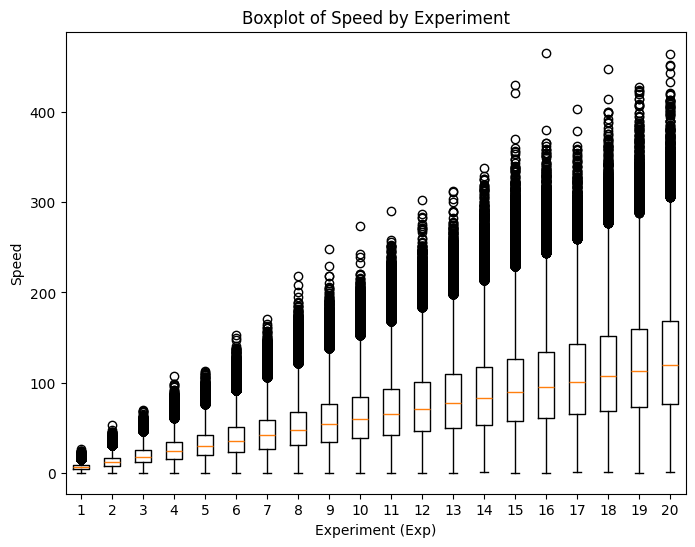

In [5]:
window=14
FPS=100
import matplotlib.pyplot as plt
df['x_future'] = df.groupby(['Exp', 'Trial'])['x'].shift(-window)
df['y_future'] = df.groupby(['Exp', 'Trial'])['y'].shift(-window)

# Compute differences in positions (dx and dy)
df['dx'] = df['x_future'] - df['x']
df['dy'] = df['y_future'] - df['y']

# Calculate the displacement vector magnitude.
df['displacement'] = (df['dx']**2 + df['dy']**2)**0.5
# Compute speed using the formula:
df['speedNew'] = FPS*df['displacement'] / window


groups = df.groupby('Exp')['speedNew']
data = [grp.dropna().values for _, grp in groups]
labels = [str(exp) for exp, _ in groups]

# Plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, tick_labels=labels)
plt.xlabel('Experiment (Exp)')
plt.ylabel('Speed')
plt.title('Boxplot of Speed by Experiment')
plt.show()


Note that as per our definition the speed increases with the number of fish.

Below we have a similar example to show how the average position of the fish is dependent on the trial number:

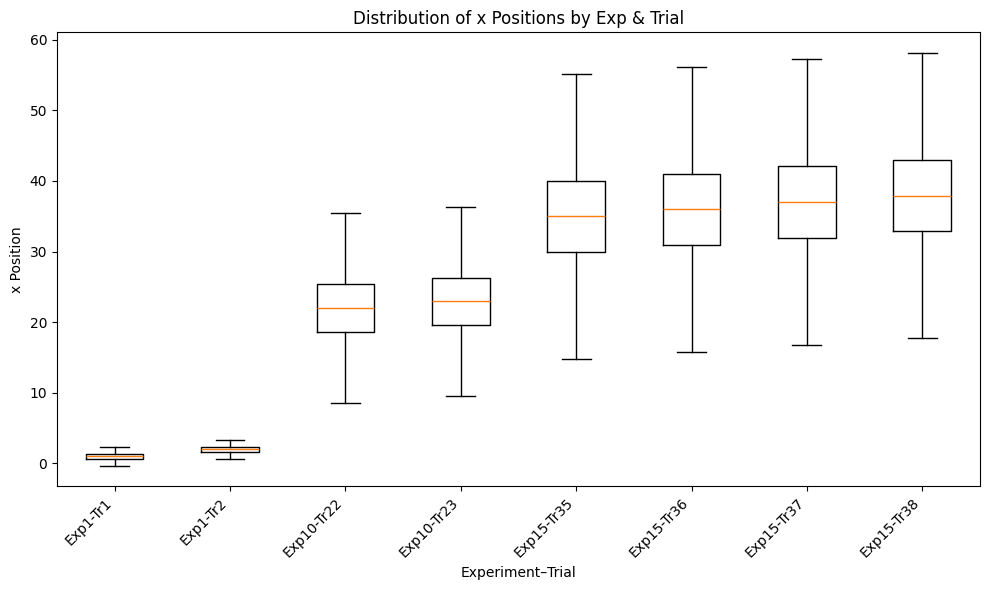

In [8]:
# 1. Filter to only Exp 1 and Exp 4
df_sub = df[df['Exp'].isin([1,10, 15])]

# 2. Group by Exp and Trial, then collect the x‐positions
grouped = df_sub.groupby(['Exp', 'Trial'])['x']

# 3. Build the data and labels for the boxplot
data   = [grp.dropna().values for _, grp in grouped]
labels = [f"Exp{exp}-Tr{trial}" for (exp, trial), _ in grouped]

# 4. Plot
plt.figure(figsize=(10, 6))
plt.boxplot(data, tick_labels=labels, showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Experiment–Trial')
plt.ylabel('x Position')
plt.title('Distribution of x Positions by Exp & Trial')
plt.tight_layout()
plt.show()
